In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import math
import os 
from datetime import datetime


## import our module
import cifar10

In [23]:
# show all the output 
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [24]:
cifar10.maybe_download_and_extract()

Data has apparently already been downloaded and unpacked.


In [25]:
class_names = cifar10.load_class_names()
class_names

Loading data: data/CIFAR-10/cifar-10-batches-py/batches.meta


['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [26]:
images_train, cls_train, labels_train = cifar10.load_training_data()
images_test, cls_test, labels_test = cifar10.load_test_data()

Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_1
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_2
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_3
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_4
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_5
Loading data: data/CIFAR-10/cifar-10-batches-py/test_batch


# Only for checking purpose

In [53]:
######only for checking purpose
images_train = images_train[0:10,:,:,:]
labels_train = labels_train[0:10,:]

images_test = images_test[0:10,:,:,:]
labels_test= labels_test[0:10,:]

In [54]:
# Check the data shape 
images_train.shape
images_test.shape
labels_train.shape   ##label_train and test_train is the one-hot coded label 
labels_test.shape

(10, 32, 32, 3)

(10, 32, 32, 3)

(10, 10)

(10, 10)

### Define Different help-Function

#### 1. For pre-process image

In [55]:
def pre_process_image(image, training):
    # This function takes a single image as input,
    # and a boolean whether to build the training or testing graph.
    
    if training:
        # For training, add the following to the TensorFlow graph.

        # Randomly crop the input image.
        image = tf.random_crop(image, size=[img_size_cropped, img_size_cropped, num_channels])

        # Randomly flip the image horizontally.
        image = tf.image.random_flip_left_right(image)
        
        # Randomly adjust hue, contrast and saturation.
        image = tf.image.random_hue(image, max_delta=0.05)
        image = tf.image.random_contrast(image, lower=0.3, upper=1.0)
        image = tf.image.random_brightness(image, max_delta=0.2)
        image = tf.image.random_saturation(image, lower=0.0, upper=2.0)

        # Some of these functions may overflow and result in pixel
        # values beyond the [0, 1] range. It is unclear from the
        # documentation of TensorFlow 0.10.0rc0 whether this is
        # intended. A simple solution is to limit the range.

        # Limit the image pixels between [0, 1] in case of overflow.
        image = tf.minimum(image, 1.0)
        image = tf.maximum(image, 0.0)
    else:
        # For training, add the following to the TensorFlow graph.

        # Crop the input image around the centre so it is the same
        # size as images that are randomly cropped during training.
        image = tf.image.resize_image_with_crop_or_pad(image,
                                                       target_height=img_size_cropped,
                                                       target_width=img_size_cropped)

    return image


def pre_process(images, training):
    # Use TensorFlow to loop over all the input images and call
    # the function above which takes a single image as input.
    images = tf.map_fn(lambda image: pre_process_image(image, training), images)

    return images

#### 2. For get the cross entropy and the accuracy: 

In [56]:
## The teo functions are from script for class
def compute_cross_entropy(logits, y):
    # Compute the average cross-entropy across all the examples.
    numerical_instability_example = 0
    if numerical_instability_example:
        y_pred = tf.nn.softmax(logits, name='y_pred') # the predicted probability for each example.
        cross_ent = tf.reduce_mean(-tf.reduce_sum(y * tf.log(y_pred), reduction_indices=[1]))
    else:
        sm_ce = tf.nn.softmax_cross_entropy_with_logits(labels=y,logits=logits, name='cross_ent_terms')
        cross_ent = tf.reduce_mean(sm_ce, name='cross_ent')
    return cross_ent

def compute_accuracy(logits, y):
    prediction = tf.argmax(logits, 1, name='pred_class')
    true_label = tf.argmax(y, 1, name='true_class')
    accuracy = tf.reduce_mean(tf.cast(tf.equal(prediction, true_label), tf.float32))
    return accuracy

#### 3. For better training the network
#### But we don't use it for the new version

In [57]:
def _variable_with_weight_decay(name, shape, stddev, wd):
	"""
	Helper to create an initialized Variable with weight decay

	Args:
		name: name of the variable
		shape: list of ints
		stddev: standard deviation of a truncated Gaussian
		wd: add L2Loss weight decay multiplied by this float. If None, weight
			decay is not added for this Variable.

	Returns:
		Variable Tensor
	"""
	var = _variable_on_cpu_(
		name,
		shape,
		tf.truncated_normal_initializer(stddev=stddev, dtype=tf.float32))
	if wd is not None:
		weight_decay = tf.multiply(tf.nn.l2_loss(var), wd, name='weight_loss')
		tf.add_to_collection('losses', weight_decay)
	return var


def _variable_on_cpu_(name, shape, initializer):
	"""
	Helper to create a Variable stored on CPU memory

	Args:
		name: name of the variable
		shape: list of ints
		initializer: initializer for Variable

	Returns:
		Variable Tensor

	"""
	with tf.device('/cpu:0'):
		var = tf.get_variable(name, shape, initializer=initializer, dtype=tf.float32)
	return var

#### 4.  For defining the Network

In [137]:
def conv(x, W):
    """simple wrapper for tf.nn.conv2d"""
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def maxpool(x):
    """simple wrapper for tf.nn.max_pool with kernel size 3, stride size 2"""
    return tf.nn.max_pool(x, ksize=[1, 3, 3, 1], strides=[1, 2, 2, 1], padding='SAME')

def avgpool(x, k = 3, s = 2, p = 'SAME'):
    """simple wrapper for tf.nn.max_pool with kernel size 3, stride size 2"""
    return tf.nn.avg_pool(x, ksize=[1, k, k, 1], strides=[1, s, s, 1], padding= p)

def dropout(x):
    """simple wrapper for tf.nn.dropout with dropout ratio 0.5"""
    return tf.nn.dropout(x, 0.5)
    

def compute_logits(x):
    x_image = tf.reshape(x, [-1, 32, 32, 3])
    # conv1 / relu1
    W_conv1 = tf.get_variable('W_conv1', shape = [5, 5, 3, 192])
    b_conv1 = tf.get_variable('b_conv1', shape = [192])
    h_conv1 = tf.nn.relu(tf.add(conv(x_image, W_conv1), b_conv1))
    #print(h_conv1)
    #print("fucccccccccccccccccccccccccck")
    # cccp1 / relu_cccp1
    W_cccp1 = tf.get_variable('W_cccp1', shape = [1, 1, 192, 160])
    b_cccp1 = tf.get_variable('b_cccp1', shape = [160])
    h_cccp1 = tf.nn.relu(tf.add(conv(h_conv1, W_cccp1), b_cccp1))
    # cccp2 / relu_cccp2
    W_cccp2 = tf.get_variable('W_cccp2', shape = [1, 1, 160, 96])
    b_cccp2 = tf.get_variable('b_cccp2', shape = [96])
    h_cccp2 = tf.nn.relu(tf.add(conv(h_cccp1, W_cccp2), b_cccp2))
    #print(h_cccp2)
    # pool
    # h_pool1 = maxpool(h_cccp2)
    h_pool1 = tf.nn.max_pool(h_cccp2, ksize=[1, 3, 3, 1], strides=[1, 2, 2, 1], padding='SAME')
   # print(h_cccp2)
    # drop3
    h_drop3 = dropout(h_pool1)
    # conv2 / relu2
    W_conv2 = tf.get_variable('W_conv2', shape = [5, 5, 96, 192])
    b_conv2 = tf.get_variable('b_conv2', shape = [192])
    h_conv2 = tf.nn.relu(tf.add(conv(h_drop3, W_conv2), b_conv2))
    # cccp3 / relu_cccp3
    #W_cccp3 = tf.get_variable('W_cccp3', shape = [1, 1, 192, 192])
    #b_cccp3 = tf.get_variable('b_cccp3', shape = [192])
    #h_cccp3 = tf.nn.relu(tf.add(conv(h_conv2, W_cccp3), b_cccp3))
    # cccp4 / relu_cccp4
    #W_cccp4 = tf.get_variable('W_cccp4', shape = [1, 1, 192, 192])
    #b_cccp4 = tf.get_variable('b_cccp4', shape = [192])
    #h_cccp4 = tf.nn.relu(tf.add(conv(h_cccp3, W_cccp4), b_cccp4))
    # poo2
    #h_pool2 = avgpool(h_cccp4)
    # h_pool2 = avgpool(h_conv2)
    h_pool2 = tf.nn.avg_pool(h_conv2, ksize=[1, 3, 3, 1], strides=[1, 2, 2, 1], padding= 'SAME')
    # drop6
    h_drop6 = dropout(h_pool2)
    # conv3 / relu3
    W_conv3 = tf.get_variable('W_conv3', shape = [3, 3, 192, 192])
    b_conv3 = tf.get_variable('b_conv3', shape = [192])
    h_conv3 = tf.nn.relu(tf.add(conv(h_drop6, W_conv3), b_conv3))
    # cccp5 / relu_cccp5
    W_cccp5 = tf.get_variable('W_cccp5', shape = [1, 1, 192, 192])
    b_cccp5 = tf.get_variable('b_cccp5', shape = [192])
    h_cccp5 = tf.nn.relu(tf.add(conv(h_conv3, W_cccp5), b_cccp5))
    # cccp6 / relu_cccp6
    W_cccp6 = tf.get_variable('W_cccp6', shape = [1, 1, 192, 10])
    b_cccp6 = tf.get_variable('b_cccp6', shape = [10])
    h_cccp6 = tf.nn.relu(tf.add(conv(h_cccp5, W_cccp6), b_cccp6))
    # pool3
    #h_pool3 = avgpool(h_cccp6, 8, 1, 'VALID')
    h_pool3 = tf.nn.avg_pool(h_cccp6, ksize=[1, 8, 8, 1], strides=[1, 8, 8, 1], padding= 'SAME')
    output_reshaped = tf.reshape(h_pool3, [-1,10])

    #print('@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@')
    #print(output_reshaped.shape)
    return output_reshaped,h_conv1,h_cccp1,h_cccp2,h_pool1,h_conv2,h_pool2,h_conv3,h_cccp5

#### 5. for Beting the random batch

In [138]:
def random_batch():
    # Number of images in the training-set.
    num_images = len(images_train)

    # Create a random index.
    idx = np.random.choice(num_images,
                           size=batch_size,
                           replace=False)

    # Use the random index to select random images and labels.
    x_batch = images_train[idx, :, :, :]
    y_batch = labels_train[idx, :]

    return x_batch, y_batch

In [139]:
len(images_train)

10

### Build the Network

**load the size and cropped size**

In [140]:
from cifar10 import img_size, num_channels, num_classes
img_size_cropped = 32

In [141]:
img_size
num_channels
num_classes

32

3

10

In [178]:
now = datetime.now()

dir_name = 'log_{0}_{1}'.format(now.month,now.day)
export_dir = 'savedmodel_{0}_{1}'.format(now.month,now.day)

batch_size = 128
num_iterations = 20000 
opt_method = 'adam'

# Global constants describing the CIFAR-10 data set.
NUM_EXAMPLES_PER_EPOCH_FOR_TRAIN = 50000
NUM_EXAMPLES_PER_EPOCH_FOR_EVAL = 10000

# Constants descrbing the training process.
MOVING_AVERAGE_DEVAY = 0.9999 # The dacay to use for moving average
NUM_EPOCHES_PER_DECAY = 350.0 # Epochs after which learning rate decays.
LEARNING_RATE_DECAY_FACTOR = 0.1 # Learning rate decat factor.
INITIAL_LEARNING_RATE = 0.1 # Initial learning rate

**Randomly Chroped the test and training image**

In [179]:
images_train_chorped = pre_process(images_train, training=True)
images_test_chorped = pre_process(images_test,training=False)

In [180]:
images_train_chorped.shape

TensorShape([Dimension(10), Dimension(32), Dimension(32), Dimension(3)])

In [181]:
builder = tf.saved_model.builder.SavedModelBuilder(export_dir)

with tf.Graph().as_default():
    
    global_step = tf.train.get_or_create_global_step()

    # Get images and labels for CIFAR-10.
    # Force input pipeline to CPU:0 to avoid operations sometimes ending up on
    # GPU and resulting in a slow down.
    with tf.device('/cpu:0'):
        
        # We build the model here as before
        x = tf.placeholder(tf.float32, shape=[None, img_size_cropped, img_size_cropped, num_channels], name='x')
        y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')
        
        with tf.name_scope('model'):
            logits,h_conv1,h_cccp1,h_cccp2,h_pool1,h_conv2,h_pool2,h_conv3,h_cccp5 = compute_logits(x)
            print('conv1:',h_conv1.shape,
                  'cccp1:',h_cccp1.shape,
                  'cccp2:',h_cccp2,
                  'pool1:',h_pool1,
                  'conv2:',h_conv2,
                  'pool2:',h_pool2,
                  'conv3:',h_conv3,
                  'cccp5:',h_cccp5)
        with tf.name_scope('loss'):
            loss = compute_cross_entropy(logits=logits, y=y_true)
        with tf.name_scope('accuracy'):
            accuracy = compute_accuracy(logits, y_true)
        
        with tf.name_scope('opt'):   
            if opt_method == 'sgd':
                opt = tf.train.GradientDescentOptimizer(0.5)
            elif opt_method == 'rms':
                opt = tf.train.RMSPropOptimizer(.001)
            elif opt_method == 'adam':
                opt = tf.train.AdamOptimizer(1e-4)
            train_step = opt.minimize(loss)
    
        with tf.name_scope('summaries'):
            # create summary for loss and accuracy
            tf.summary.scalar('loss', loss) 
            tf.summary.scalar('accuracy', accuracy)
            # create summary for logits
            tf.summary.histogram('logits', logits)
            # create summary for input image
            tf.summary.image('input', tf.reshape(x, [-1,img_size_cropped,img_size_cropped, num_channels]))
            summary_op = tf.summary.merge_all()
    
        saver = tf.train.Saver()    ##Save the model
        
        sess = tf.Session()
        summary_writer = tf.summary.FileWriter(dir_name, sess.graph)
        summary_writer_train = tf.summary.FileWriter(dir_name+'/train', sess.graph)
        summary_writer_val = tf.summary.FileWriter(dir_name+'/val')
        
        sess.run(tf.global_variables_initializer())
    
        for i in range(num_iterations):
            X_batch, y_batch = random_batch()

            # now run
            _ , summary = sess.run((train_step, summary_op),
                                      feed_dict={x: X_batch, y_true: y_batch})
                
            # write the summary output to file
            if i%100==0:
                summary_writer_train.add_summary(summary, i)
                    
                (train_error,train_logits) = sess.run((accuracy,logits), {x: X_batch, y_true: y_batch})
                print("\rStep {0:3d}: training accuracy {1:0.4f}".format(i, train_error), flush=True)
                
                X_batch2 = images_test
                y_batch2 = labels_test
                (val_error, summary) = sess.run((accuracy,summary_op), {x:X_batch2, y_true:y_batch2})
                print("\rStep {0:3d}: val accuracy {1:0.4f}".format(i, val_error), flush=True)
                summary_writer_val.add_summary(summary, i)
                saver.save(sess, './model4/model_iter', global_step=i)
                
        # Save the final model
        save_path = saver.save(sess, "./model4/model.ckpt")
        builder.add_meta_graph_and_variables(sess,["foo-tag"])
builder.save()

conv1: (?, 32, 32, 192) cccp1: (?, 32, 32, 160) cccp2: Tensor("model/Relu_2:0", shape=(?, 32, 32, 96), dtype=float32, device=/device:CPU:0) pool1: Tensor("model/MaxPool:0", shape=(?, 16, 16, 96), dtype=float32, device=/device:CPU:0) conv2: Tensor("model/Relu_3:0", shape=(?, 16, 16, 192), dtype=float32, device=/device:CPU:0) pool2: Tensor("model/AvgPool:0", shape=(?, 8, 8, 192), dtype=float32, device=/device:CPU:0) conv3: Tensor("model/Relu_4:0", shape=(?, 8, 8, 192), dtype=float32, device=/device:CPU:0) cccp5: Tensor("model/Relu_5:0", shape=(?, 8, 8, 192), dtype=float32, device=/device:CPU:0)


<tf.Tensor 'summaries/loss:0' shape=() dtype=string>

<tf.Tensor 'summaries/accuracy:0' shape=() dtype=string>

<tf.Tensor 'summaries/logits:0' shape=() dtype=string>

<tf.Tensor 'summaries/input:0' shape=() dtype=string>

Step   0: training accuracy 0.0000
Step   0: val accuracy 0.2000


'./model4/model_iter-0'

INFO:tensorflow:No assets to save.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: b'./log12/saved_model.pb'


b'./log12/saved_model.pb'

In [182]:
def getActivations(sess,layer_name,image_name):
    units = sess.run(layer_name,feed_dict={x:image_name})
    plotNNFilter(units)
    
    
def plotNNFilter(units):
    filters = units.shape[3]
    plt.figure(1, figsize=(20,20))
    n_columns = 6
    n_rows = math.ceil(filters / n_columns) + 1
    for i in range(filters):
        plt.subplot(n_rows, n_columns, i+1)
        plt.title('Filter ' + str(i))
        plt.imshow(units[0,:,:,i], interpolation="nearest", cmap="rainbow")


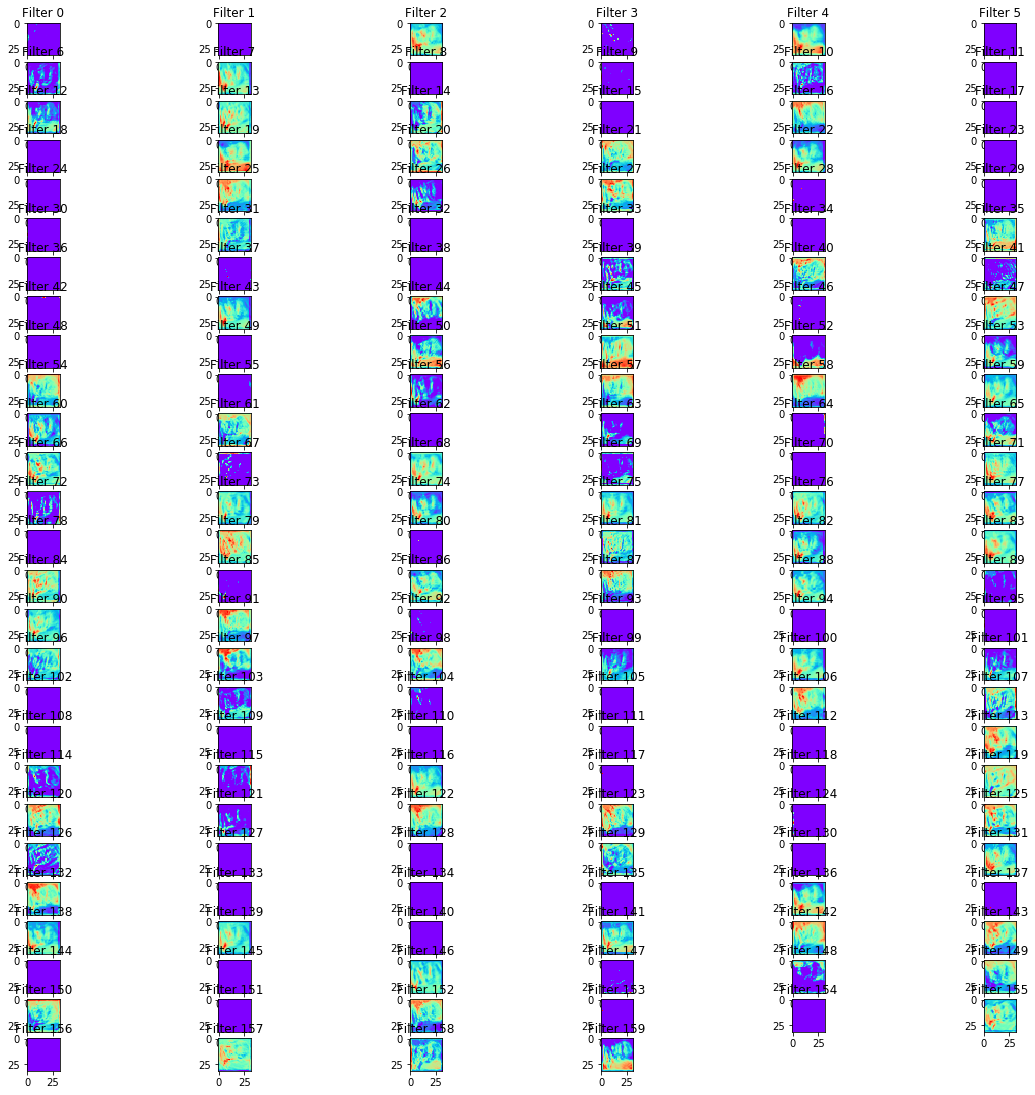

In [183]:
getActivations(sess,h_cccp1,images_test)

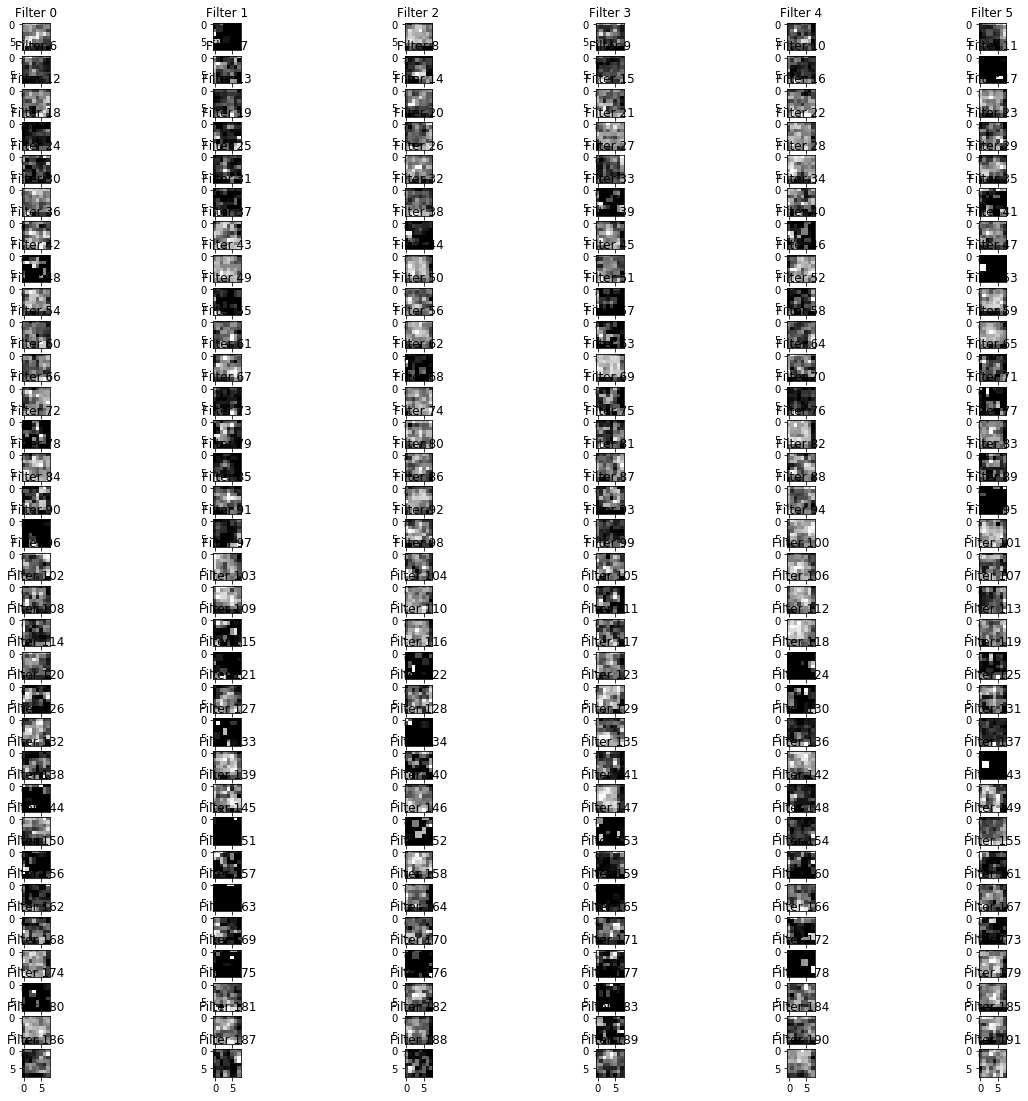

In [153]:
plotNNFilter(pool2)

In [ ]:
conv1,cccp1,cccp2,pool1,conv2,pool2,conv3,cccp5

**Plot the Imgae**

In [ ]:
def plot_images(images, cls_true, cls_pred=None, smooth=True):

    assert len(images) == len(cls_true) == 9

    # Create figure with sub-plots.
    fig, axes = plt.subplots(3, 3)

    # Adjust vertical spacing if we need to print ensemble and best-net.
    if cls_pred is None:
        hspace = 0.3
    else:
        hspace = 0.6
    fig.subplots_adjust(hspace=hspace, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Interpolation type.
        if smooth:
            interpolation = 'spline16'
        else:
            interpolation = 'nearest'

        # Plot image.
        ax.imshow(images[i, :, :, :],
                  interpolation=interpolation)
            
        # Name of the true class.
        cls_true_name = class_names[cls_true[i]]

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true_name)
        else:
            # Name of the predicted class.
            cls_pred_name = class_names[cls_pred[i]]

            xlabel = "True: {0}\nPred: {1}".format(cls_true_name, cls_pred_name)

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

In [ ]:
plot_images(images_train[1:10,:,:,:], cls_train[1:10,:], cls_pred=None, smooth=False)